In [147]:
import datetime
import os
import random
from collections.abc import Generator
from decimal import Decimal

os.chdir('/code')

import cvxpy as cp
import numpy as np
import pandas as pd

from auction_engine import engine
from auction_engine.one_inch import (
    API as one_inch_api,
    ReferenceRate,
    UnknownTokenError,
    get_reference_rate,
)
from auction_engine.models import LimitOrder

In [148]:
# Auction parameters:
from_token = 'ETH'
to_token = 'USDT'

In [149]:
reference_rate = get_reference_rate(from_token, to_token, amount=1)
reference_rate

ReferenceRate(1241.2547 USDT/ETH)

In [150]:
def generate_limit_orders(
    order_id_generator: Generator[None, None, int],
    wallet_id_generator: Generator[None, None, int],
    from_token: str,
    to_token: str,
    base_rate: ReferenceRate,
    min_amount: int = 1,
    max_amount: int = 1000,
) -> list:
    if from_token not in one_inch_api.tokens:
        raise UnknownTokenError(from_token)
    if to_token not in one_inch_api.tokens:
        raise UnknownTokenError(to_token)
    
    rate_pair = (base_rate.from_token, base_rate.to_token)

    match (from_token, to_token):
        case (base_rate.from_token, base_rate.to_token):
            # BUY
            rate = base_rate.rate
        case (base_rate.to_token, base_rate.from_token):
            # SELL
            rate = base_rate.rate**-1
        case _:
            raise ValueError(f'Unrecognized base_rate pair: {rate_pair}') 

    orders = [
        LimitOrder(
            order_id=order_id,
            wallet_id=wallet_id,
            from_token=from_token,
            to_token=to_token,
            from_token_amount=random.randint(min_amount, max_amount),
            sent_timestamp=datetime.datetime.utcnow(),
            rate_upper_limit=Decimal(random.uniform(-0.1, 0.01) + 1) * rate,
            rate_lower_limit=Decimal(random.uniform(-0.2, -0.1) + 1) * rate,
        )
        for order_id, wallet_id, in zip(
            order_id_generator,
            wallet_id_generator,
        )
    ]
    return orders

num_buys = 200
num_sells = 200

buy_gen = range(num_buys)
sell_gen = range(num_buys, num_buys + num_sells)

buy_orders = generate_limit_orders(
    order_id_generator=buy_gen,
    wallet_id_generator=buy_gen,
    from_token=from_token,
    to_token=to_token,
    base_rate=reference_rate,
)
sell_orders = generate_limit_orders(
    order_id_generator=sell_gen,
    wallet_id_generator=sell_gen,
    from_token=to_token,
    to_token=from_token,
    base_rate=reference_rate,
)
all_orders = buy_orders + sell_orders

order_book = pd.DataFrame.from_records([order.dict() for order in all_orders])
order_book

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit
0,0,0,ETH,USDT,493,2022-06-25 23:39:28.335132,1225.705272801476724244307270,1049.929243364669816124890023
1,1,1,ETH,USDT,288,2022-06-25 23:39:28.335224,1140.793459264621267887651612,1019.208737333321059707347267
2,2,2,ETH,USDT,33,2022-06-25 23:39:28.335252,1235.951431436572530329431885,1065.621754790181317726305288
3,3,3,ETH,USDT,989,2022-06-25 23:39:28.335374,1145.603554632677076681612771,1054.165185132571850382110501
4,4,4,ETH,USDT,665,2022-06-25 23:39:28.335403,1214.908779697326017432534861,1050.938620899036099192214166
...,...,...,...,...,...,...,...,...
395,395,395,USDT,ETH,589,2022-06-25 23:39:28.350698,0.0007595320947703573950441972911,0.0007120422665751132754786071960
396,396,396,USDT,ETH,713,2022-06-25 23:39:28.350723,0.0007775907086417111846813040750,0.0006896729459015964984023100333
397,397,397,USDT,ETH,151,2022-06-25 23:39:28.350745,0.0008089508839219800517647183995,0.0006466657983351945622286819951
398,398,398,USDT,ETH,746,2022-06-25 23:39:28.350840,0.0008124103847760165039100022708,0.0006789835723275587644004857236


In [151]:
standard_pair = f'{from_token}/{to_token}'
order_book['pair'] = order_book['from_token'] + '/' + order_book['to_token']
fltr_standard_pair = order_book['pair'].eq(standard_pair)

for rate in ['rate_upper_limit', 'rate_lower_limit']:
    standard_rate = order_book[rate].copy()
    standard_rate[~fltr_standard_pair] = -standard_rate.loc[~fltr_standard_pair].pow(-1)
    order_book[f'standard_{rate}'] = standard_rate

order_book['standard_pair'] = standard_pair
order_book['standard_amount'] = order_book['from_token_amount']
order_book['side'] = order_book['pair'].map({standard_pair: 'BUY'}).fillna('SELL')
order_book.sort_values('side')

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side
0,0,0,ETH,USDT,493,2022-06-25 23:39:28.335132,1225.705272801476724244307270,1049.929243364669816124890023,ETH/USDT,1225.705272801476724244307270,1049.929243364669816124890023,ETH/USDT,493,BUY
127,127,127,ETH,USDT,188,2022-06-25 23:39:28.339649,1242.994305737782710231265071,1065.086248572589218212458562,ETH/USDT,1242.994305737782710231265071,1065.086248572589218212458562,ETH/USDT,188,BUY
128,128,128,ETH,USDT,942,2022-06-25 23:39:28.339677,1147.635766375710861017889197,1035.191499104864614938503742,ETH/USDT,1147.635766375710861017889197,1035.191499104864614938503742,ETH/USDT,942,BUY
129,129,129,ETH,USDT,944,2022-06-25 23:39:28.339702,1122.454604889784671642871672,1035.441407742083343106231919,ETH/USDT,1122.454604889784671642871672,1035.441407742083343106231919,ETH/USDT,944,BUY
130,130,130,ETH,USDT,559,2022-06-25 23:39:28.339742,1206.167974515267432624243682,1061.192262172378209297440854,ETH/USDT,1206.167974515267432624243682,1061.192262172378209297440854,ETH/USDT,559,BUY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,269,269,USDT,ETH,205,2022-06-25 23:39:28.345552,0.0007625514112412609830309259598,0.0006472325931428334127969254761,USDT/ETH,-1311.386990120740181319398324,-1545.039620369236748428390380,ETH/USDT,205,SELL
270,270,270,USDT,ETH,868,2022-06-25 23:39:28.345576,0.0007452835135380696026706475481,0.0007189050086597544411715987893,USDT/ETH,-1341.771261318689161110369714,-1391.004357953058934806336798,ETH/USDT,868,SELL
271,271,271,USDT,ETH,530,2022-06-25 23:39:28.345599,0.0007629344026234880132109690323,0.0007065533264657973958012297201,USDT/ETH,-1310.728676752967264245412790,-1415.321338874777310340223319,ETH/USDT,530,SELL
261,261,261,USDT,ETH,389,2022-06-25 23:39:28.345316,0.0007843756398509155365393872892,0.0007240485521594610644507798459,USDT/ETH,-1274.899358412083892374761803,-1381.122850142464866332593198,ETH/USDT,389,SELL


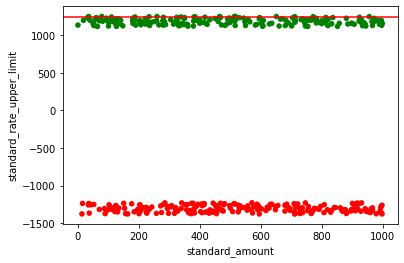

In [152]:
plt = order_book.plot.scatter(
    x='standard_amount',
    y='standard_rate_upper_limit',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
)
plt.axhline(y=reference_rate.rate, color='r', linestyle='-')


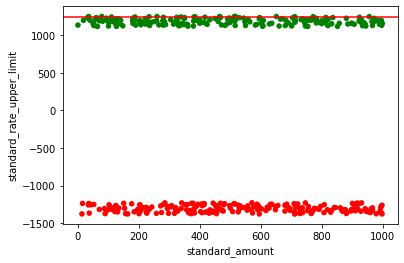

In [153]:
plt = order_book.plot.scatter(
    x='standard_amount',
    y='standard_rate_upper_limit',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
)
plt.axhline(y=reference_rate.rate, color='r', linestyle='-')

In [154]:
# Optimization problem
side = order_book['side'].map({'BUY': 1, 'SELL': -1}).values

n = len(order_book)
x = cp.Variable(n)                                              # Auction fill quantity
p_h = order_book['standard_rate_upper_limit'].values            # upper bound
p_l = order_book['standard_rate_lower_limit'].values            # lower bound
w = side                                                        # "Portfolio" weights
q = order_book['standard_amount'].values                        # Order quantity

D = np.diag((p_h - p_l) / (2 * q))
objective = cp.Maximize(x @ p_h - cp.quad_form(x, D))
constraints = [
    x @ w == 0,
    x >= 0,
    x <= q,
]
problem = cp.Problem(objective, constraints)
problem.solve()

1827.1523819146184

In [155]:
(p_l > p_h).any()

False

In [156]:
clearing_price = problem.constraints[0].dual_value
clearing_price

array(1240.5305432)

In [157]:
reference_rate

ReferenceRate(1241.2547 USDT/ETH)

In [163]:
problem.solution.status

'optimal'

In [166]:
problem.variables()[0].value

array([ 2.64055110e-17,  2.64055772e-17,  1.16226934e-17,  2.64056169e-17,
        2.64056169e-17,  2.64055374e-17,  2.64056698e-17,  2.64056169e-17,
        1.97177111e-17,  2.36764306e-18,  2.64055904e-17,  1.96493166e-17,
        2.64055639e-17,  2.64055904e-17,  2.64055110e-17,  2.64055110e-17,
        1.62363666e-17,  2.64055639e-17,  2.64055904e-17,  2.64055110e-17,
        2.64055639e-17,  2.64055110e-17,  2.04920310e+01,  2.64056169e-17,
        2.36578893e-17,  2.64055374e-17,  2.64055110e-17,  2.29162900e-17,
        2.64055639e-17,  2.64055110e-17,  2.64055772e-17,  2.64051933e-17,
        2.64055904e-17,  1.79279019e+01,  7.36621998e-01,  2.64055308e-17,
        1.73270939e+00,  2.64055904e-17,  2.64055110e-17,  2.64055639e-17,
        2.64055639e-17,  2.64055374e-17,  2.64056169e-17,  2.00416640e-17,
        2.64055639e-17,  2.64055110e-17,  2.64054051e-17,  2.64055639e-17,
        2.64056169e-17,  2.64055639e-17,  2.64054845e-17,  2.64055110e-17,
        2.64055904e-17,  

In [159]:
x.value

array([ 2.64055110e-17,  2.64055772e-17,  1.16226934e-17,  2.64056169e-17,
        2.64056169e-17,  2.64055374e-17,  2.64056698e-17,  2.64056169e-17,
        1.97177111e-17,  2.36764306e-18,  2.64055904e-17,  1.96493166e-17,
        2.64055639e-17,  2.64055904e-17,  2.64055110e-17,  2.64055110e-17,
        1.62363666e-17,  2.64055639e-17,  2.64055904e-17,  2.64055110e-17,
        2.64055639e-17,  2.64055110e-17,  2.04920310e+01,  2.64056169e-17,
        2.36578893e-17,  2.64055374e-17,  2.64055110e-17,  2.29162900e-17,
        2.64055639e-17,  2.64055110e-17,  2.64055772e-17,  2.64051933e-17,
        2.64055904e-17,  1.79279019e+01,  7.36621998e-01,  2.64055308e-17,
        1.73270939e+00,  2.64055904e-17,  2.64055110e-17,  2.64055639e-17,
        2.64055639e-17,  2.64055374e-17,  2.64056169e-17,  2.00416640e-17,
        2.64055639e-17,  2.64055110e-17,  2.64054051e-17,  2.64055639e-17,
        2.64056169e-17,  2.64055639e-17,  2.64054845e-17,  2.64055110e-17,
        2.64055904e-17,  

In [158]:
order_book['optimal_fill'] = x.value

order_book.head()

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill
0,0,0,ETH,USDT,493,2022-06-25 23:39:28.335132,1225.705272801476724244307270,1049.929243364669816124890023,ETH/USDT,1225.705272801476724244307270,1049.929243364669816124890023,ETH/USDT,493,BUY,2.640551e-17
1,1,1,ETH,USDT,288,2022-06-25 23:39:28.335224,1140.793459264621267887651612,1019.208737333321059707347267,ETH/USDT,1140.793459264621267887651612,1019.208737333321059707347267,ETH/USDT,288,BUY,2.640558e-17
2,2,2,ETH,USDT,33,2022-06-25 23:39:28.335252,1235.951431436572530329431885,1065.621754790181317726305288,ETH/USDT,1235.951431436572530329431885,1065.621754790181317726305288,ETH/USDT,33,BUY,1.162269e-17
3,3,3,ETH,USDT,989,2022-06-25 23:39:28.335374,1145.603554632677076681612771,1054.165185132571850382110501,ETH/USDT,1145.603554632677076681612771,1054.165185132571850382110501,ETH/USDT,989,BUY,2.640562e-17
4,4,4,ETH,USDT,665,2022-06-25 23:39:28.335403,1214.908779697326017432534861,1050.938620899036099192214166,ETH/USDT,1214.908779697326017432534861,1050.938620899036099192214166,ETH/USDT,665,BUY,2.640562e-17


In [130]:
order_book['fill_status'] = None
fltr_filled = order_book['optimal_fill'].eq(order_book['standard_amount'])
fltr_partial = order_book['optimal_fill'].between(0, order_book['standard_amount'], inclusive='neither')
fltr_unfilled = order_book['optimal_fill'].lt(1e-8)

states = {
    'filled': fltr_filled,
    'partial': fltr_partial,
    'unfilled': fltr_unfilled,
}

for state, fltr in states.items():
    order_book.loc[fltr, 'fill_status'] = state

order_book['fill_status'].value_counts()

unfilled    366
partial      34
Name: fill_status, dtype: int64

In [131]:
order_book.loc[fltr_partial]

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
0,0,0,ETH,USDT,477,2022-06-25 21:31:48.777406,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,477,BUY,9.974660e-14,unfilled,2.091124e-16
1,1,1,ETH,USDT,979,2022-06-25 21:31:48.777607,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,979,BUY,9.974313e-14,unfilled,1.018827e-16
2,2,2,ETH,USDT,957,2022-06-25 21:31:48.777669,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,957,BUY,9.974660e-14,unfilled,1.042284e-16
3,3,3,ETH,USDT,519,2022-06-25 21:31:48.777712,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,519,BUY,1.278405e+02,partial,2.463208e-01
4,4,4,ETH,USDT,751,2022-06-25 21:31:48.777753,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,751,BUY,9.974660e-14,unfilled,1.328184e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,327,327,USDT,ETH,547,2022-06-25 21:31:48.793760,0.0008262268806224561019204425746,0.0008179646118162315335628692974,USDT/ETH,-1210.321309380091961776917701,-1222.546777151608053166984189,ETH/USDT,547,SELL,1.056237e+01,partial,1.930963e-02
347,347,347,USDT,ETH,957,2022-06-25 21:31:48.795073,0.0008318936944909795706224351644,0.0008235747575460697675275105434,USDT/ETH,-1202.076667514449164617069440,-1214.218856075201187274241705,ETH/USDT,957,SELL,6.683618e+02,partial,6.983927e-01
354,354,354,USDT,ETH,425,2022-06-25 21:31:48.795391,0.0008287281782571187458720628979,0.0008204408964745475510527574317,USDT/ETH,-1206.668273429629862123701184,-1218.856841848110982777095576,ETH/USDT,425,SELL,1.356076e+02,partial,3.190768e-01
383,383,383,USDT,ETH,503,2022-06-25 21:31:48.796706,0.0008308119816900596352742757431,0.0008225038618731590315424402560,USDT/ETH,-1203.641764970425243137680307,-1215.799762596389145390051944,ETH/USDT,503,SELL,2.861102e+02,partial,5.688076e-01


In [132]:
order_book['fill_pct'] = order_book['optimal_fill'] / order_book['standard_amount']
order_book.sort_values('fill_pct')

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
251,251,251,USDT,ETH,4,2022-06-25 21:31:48.791562,0.0007592267045228941108106048377,0.0007516344374776651629592110432,USDT/ETH,-1317.129645259791422351753822,-1330.433985110900438553920572,ETH/USDT,4,SELL,-5.469264e-14,unfilled,-1.367316e-14
363,363,363,USDT,ETH,20,2022-06-25 21:31:48.795743,0.0007794736929764476047018020849,0.0007716789560466831217316669358,USDT/ETH,-1282.916933580484244456008195,-1295.875690485337632288582247,ETH/USDT,20,SELL,-9.974600e-14,unfilled,-4.987300e-15
290,290,290,USDT,ETH,22,2022-06-25 21:31:48.792623,0.0007803686354409518448380482369,0.0007725649490865423194586019404,USDT/ETH,-1281.445658608439808420671235,-1294.389554149939212037535275,ETH/USDT,22,SELL,-9.974603e-14,unfilled,-4.533910e-15
373,373,373,USDT,ETH,38,2022-06-25 21:31:48.796152,0.0008023345493078880038708128129,0.0007943112038148091167059423640,USDT/ETH,-1246.362880499939459324214184,-1258.952404545393404551472481,ETH/USDT,38,SELL,-9.974600e-14,unfilled,-2.624895e-15
365,365,365,USDT,ETH,38,2022-06-25 21:31:48.795914,0.0007480966707124416991929422887,0.0007406157040053172755565796780,USDT/ETH,-1336.725638743534194021723649,-1350.227917922761824256723872,ETH/USDT,38,SELL,-9.974600e-14,unfilled,-2.624895e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,314,314,USDT,ETH,495,2022-06-25 21:31:48.793364,0.0008331710484893636622672253537,0.0008248393380044700182445076483,USDT/ETH,-1200.233735693428972251554526,-1212.357308781241396989343952,ETH/USDT,495,SELL,4.215066e+02,partial,8.515286e-01
21,21,21,ETH,USDT,742,2022-06-25 21:31:48.779320,1221.107842192598490227545494,1208.896763770672494479653703,ETH/USDT,1221.107842192598490227545494,1208.896763770672494479653703,ETH/USDT,742,BUY,6.410723e+02,partial,8.639788e-01
282,282,282,USDT,ETH,569,2022-06-25 21:31:48.792441,0.0008332985759551849475459878849,0.0008249655901956330906693498827,USDT/ETH,-1200.050052712174928833355072,-1212.171770416338322827881967,ETH/USDT,569,SELL,4.932136e+02,partial,8.668078e-01
286,286,286,USDT,ETH,250,2022-06-25 21:31:48.792535,0.0008334235988597198628830818448,0.0008250893628711226568519624766,USDT/ETH,-1199.870031719989647871923392,-1211.989931030292584481370109,ETH/USDT,250,SELL,2.204502e+02,partial,8.818008e-01


In [142]:
grp = order_book.groupby('side')
fill_value = grp[['standard_amount', 'optimal_fill']].sum()
fill_status_counts = grp[['fill_status']].value_counts().unstack()
orders = grp.apply(len)
stats = pd.concat([fill_value, fill_status_counts, orders], axis=1)
stats.columns = ['order_amount', 'fill_amount', 'partial', 'unfilled', 'total']
stats

,order_amount,fill_amount,partial,unfilled,total
side,,,,,
BUY,100680,4129.53437,17,183,200
SELL,100421,4129.53437,17,183,200


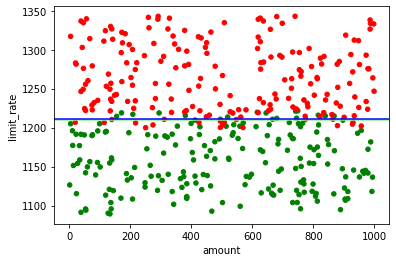

In [146]:
col_map = {
    'standard_amount': 'amount',
    'side': 'side',
    'standard_pair': 'pair',
    'standard_rate_upper_limit': 'limit_rate',
}
plot_data = order_book[col_map.keys()].rename(columns=col_map).copy()
plot_data['limit_rate'] = plot_data['limit_rate'].abs()

plt = plot_data.plot.scatter(
    x='amount',
    y='limit_rate',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
    title=''
)
plt.axhline(y=reference_rate.rate, color='lightgreen', linestyle='-')
plt.axhline(y=clearing_price, color='blue', linestyle='-')